# 50:50 beads

In [4]:
from labvision.video import ReadVideo
from labvision.images import display, threshold, median_blur
from labvision.images.cropmask import mask_circle, apply_mask
from particletracker import batchprocess, track_gui
from filehandling import BatchProcess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Fig 2 analysis

We track the position of the bead using particletracker and use the position data relative to centre of cell to create a heatmap.
We also calcualte the fraction of blue visible to the camera. Fluctuations in this fraction tell us about rotation and also whether the charging is resulting in a downwards correlation resulting from charge imbalance on the two sides.

Next bits create raw data

### Tracking

In [17]:
# Track the position of the beads
path='E:/RawData/Mike/5050_beads/'
filename='P1001895.mp4'
settings = 'track_5050.param'
track_gui(path + filename, path + settings)
#batchprocess(path + filename, path + settings)

Empty DataFrame
Columns: []
Index: []


Annotating: 100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


Empty DataFrame
Columns: []
Index: []


Annotating: 100%|██████████| 1/1 [00:00<00:00, 250.21it/s]


Coords
1064.0142095914744 559.2895204262878
Intensities [r,g,b]
[ 66 128 232]
Coords
1208.0565779719268 552.193987479287
Intensities [r,g,b]
[ 82  96 117]
Coords
1209.114420859818 557.4832019187438
Intensities [r,g,b]
[39 53 74]
Coords
1209.114420859818 553.2518303671784
Intensities [r,g,b]
[42 56 77]
Coords
1062.0742594429198 556.4253590308524
Intensities [r,g,b]
[ 65  91 165]
Coords
1062.0742594429198 556.4253590308524
Intensities [r,g,b]
[ 65  91 165]


### 50:50

In [2]:
#Calculate the fraction of blue in the image
def fraction_blue(img):
    mask = ((1096, 532), (1560, 844))
    mask_img = mask_circle(np.shape(img[:,:,0]), mask)
    img = median_blur(img)
    red_img=apply_mask(threshold(img[:,:,2], value=100), mask_img)
    blue_img=apply_mask(threshold(img[:,:,0], value=100),mask_img)
    fraction = np.sum(np.sum(red_img))/(np.sum(np.sum(blue_img)))
    return fraction

def process_5050(filepath):
    vid = ReadVideo(filepath, frame_range=(0, None, 1))
    fraction_data = pd.DataFrame(index=np.linspace(0,vid.num_frames-1, vid.num_frames, dtype=int), data=np.zeros(vid.num_frames))
    for idx, frame in enumerate(vid):
        fraction_data.loc[idx] = fraction_blue(frame)

    fraction_data.to_csv(filepath[:-4] + '_fraction_data.csv', header='fraction',index=True)

In [ ]:
from multiprocessing import process

path='E:/RawData/Mike/5050_beads/'
filename='P100189?.mp4'
#process_5050(path + filename)
for filepath in BatchProcess(path + filename):
    print(filepath)
    process_5050(filepath)


### Extract plot of fraction against time

E:/RawData/Mike/5050_beads/P1001896.hdf5


(0.0, 200.0)

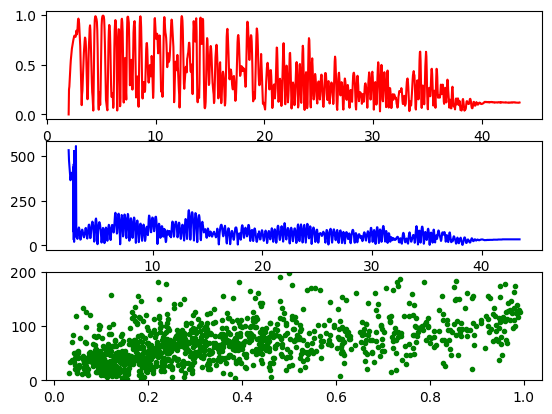

In [10]:
#reprocessed 892, 893
# 891, 892, 893?, 895, 896
fps=30.0
path='E:/RawData/Mike/5050_beads/'
filename='P1001896.hdf5'
filename2 = filename[:-5] + '_fraction_data.csv'

print(path + filename)
mask = ((1096, 532), (1560, 844))

fraction_data = pd.read_csv(path + filename2)
tracking_data = pd.read_hdf(path + filename)
middle = (np.mean(tracking_data['x'][:-200]), np.mean(tracking_data['y'][:-200]))
tracking_data['dr'] = ((tracking_data['x'] - middle[0])**2 + (tracking_data['y'] - middle[1])**2)**0.5

fig, ax = plt.subplots(nrows=3,ncols=1)
ax[0].plot(fraction_data.index/fps, fraction_data.fraction,'r-')
ax[1].plot(tracking_data.index/fps, tracking_data.dr,'b-')
index_vals = tracking_data.index
ax[2].plot(fraction_data.fraction.loc[index_vals], tracking_data.dr,'g.')
ax[2].set_ylim([0,200])


### Extract heatmap from tracking data

In [ ]:
from labvision.video import ReadVideo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patch


def plot_heatmap(heatmap):
    print('num_pixels:')
    num_pixels = np.count_nonzero(heatmap)
    print(num_pixels)

    f = plt.figure(figsize=(6.2, 5.6))
    ax = f.add_axes([0.1, 0.1, 0.72, 0.72])
    axcolor = f.add_axes([0.90, 0.1, 0.02, 0.72])
    im = ax.matshow(heatmap, cmap='jet', norm=LogNorm(vmin=0.1, vmax=np.max(np.max(heatmap))))
    
    #find indices of max value in heatmap
    cy = np.argmax(np.sum(heatmap,axis=1))
    cx = np.argmax(np.sum(heatmap,axis=0))
    rad_px = int((1208-1062)/2)

    circ = patch.Circle((int(cx),int(cy)), radius=rad_px, fill=False, color='b', linestyle='--')
    ax.add_patch(circ)

    #t = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    f.colorbar(im, cax=axcolor, format="%.2f")

def create_heatmap(filepath, crop=100):
    df = pd.read_hdf(filepath)    
    max_val = int(np.ceil(df['x'].max() if df['x'].max() > df['y'].max() else df['y'].max()))
    min_val = int(np.floor(df['x'].min() if df['x'].min() < df['y'].min() else df['y'].min()))
    diff = max_val - min_val

    heatmap = np.zeros((diff,diff))
    for idx, row in df.iterrows():
        x = int(row['x'])-min_val
        y = int(row['y']) - min_val
        heatmap[x-5:x+5,y-5:y+5] += 1

    #find indices of max value in heatmap
    cy = np.argmax(np.sum(heatmap,axis=1))
    cx = np.argmax(np.sum(heatmap,axis=0))
    heatmap = heatmap[cy-crop:cy+crop,cx-crop:cx+crop]

    plot_heatmap(heatmap)
    plt.show()

path='E:/RawData/Mike/5050_beads/'
filename='P1001896.hdf5'
create_heatmap(path + filename)

: 